In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import os

In [ ]:
def fetch_stock_data(ticker, start_date, end_date, output_dir="."):
    """Fetch historical stock data from Yahoo Finance."""
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    data.to_csv(f"{output_dir}/{ticker}_data_{start_date}_{end_date}.csv", header=True, index=True)
    return data

data = fetch_stock_data("RDC.DE", "2021-01-01", datetime.today().strftime('%Y-%m-%d'), output_dir="../data/raw")

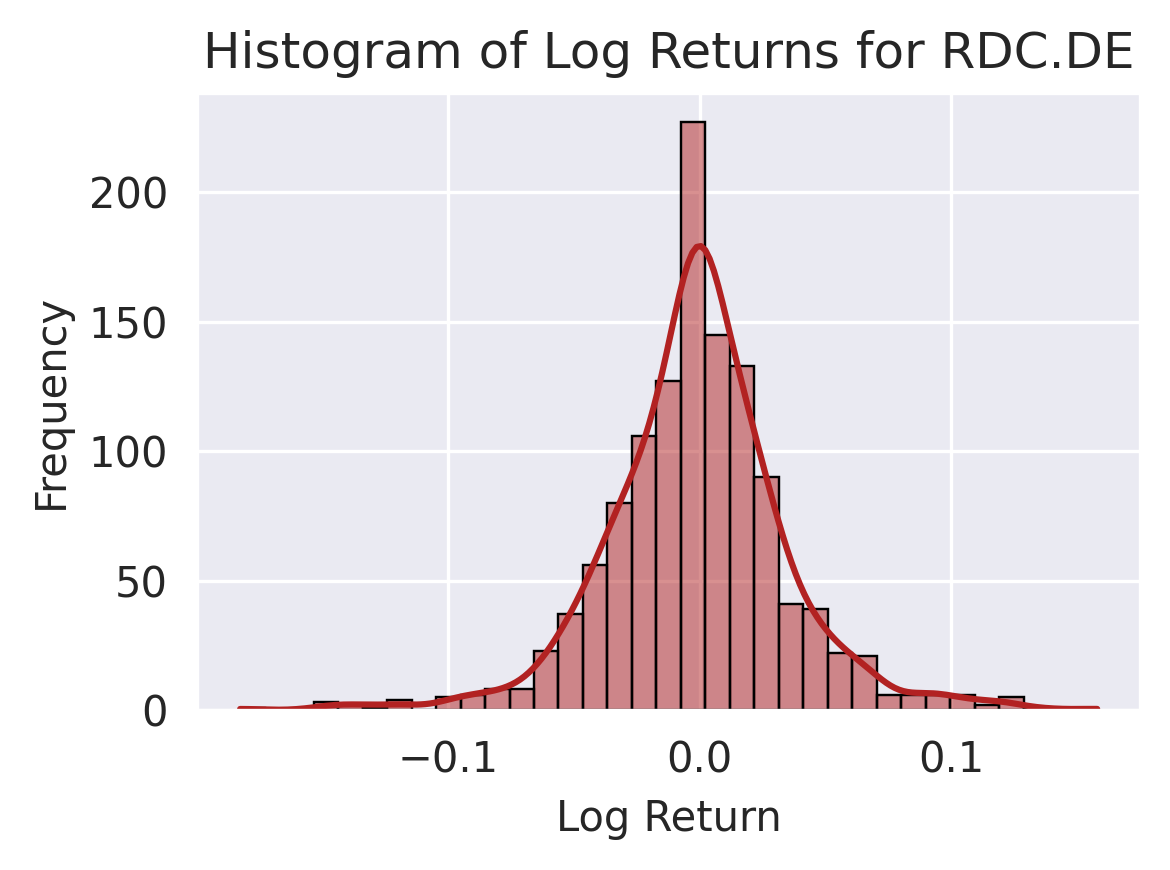

In [ ]:
def calculate_log_returns(data):
    """Calculate log returns of the closing prices."""
    data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)
    return data
data = calculate_log_returns(data)

In [ ]:
def plot_log_return_histogram(data, output_dir="."):
    """Plot histogram of log returns."""
    plt.figure(dpi=300, figsize=(4, 3), tight_layout=True)
    sns.set_style('darkgrid')
    sns.histplot(x=data['Log Return'], bins=35, kde=True, color='firebrick', stat='count', edgecolor='black', )
    plt.title('Histogram of Log Returns for RDC.DE')
    plt.xlabel('Log Return')
    plt.ylabel('Frequency')
    plt.savefig(os.path.join(output_dir, 'RDC_DE_log_return_histogram.png'))
    plt.show()
plot_log_return_histogram(data, output_dir="../results/plots")